In [1]:
import pandas as pd
import numpy as np

import re
import string
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from Method import *

# word cloud library
from wordcloud import WordCloud

# Vectorize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import TruncatedSVD


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Table of content
+ EDA
+ Preprocessing
+ Modeling
+ Predict
+ Visualize output

In [2]:
# Read data
data= pd.read_csv("Dataset\Reviews.csv")
data.drop_duplicates(subset = 'Text',inplace=True)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.shape

(393579, 10)

# EDA
+ Word count
+ Sentence count

# Preprocessing
+ Lower, remove punctual
+ Remove Stopwords 
+ Lemmatize

In [4]:
# Clean text
df_sampled = preprocess_data(data)
df = df_sampled[['Text']].iloc[:390000]
df = df['Text'].apply(lambda x: preprocess_text(x, tokenize=False))
df.drop_duplicates(inplace=True)
df.head()

0    bought several vitality canned food product fo...
1    product arrived labeled jumbo salted peanutsth...
2    confection around century light pillowy citrus...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

In [5]:
df[0]

'bought several vitality canned food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better'

+ Vectorize

In [6]:
# Vectorize
# vect =TfidfVectorizer(max_features=500)
vect =CountVectorizer(max_features=500)

vect_text = vect.fit_transform(df)

In [7]:
vect_text.data.shape

(6659723,)

# Modeling

In [8]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, end, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, end, step):
        model = gensim.models.LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

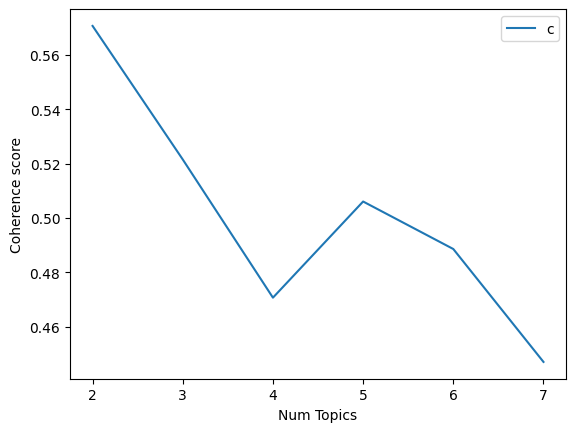

Num Topics = 2  has Coherence Value of 0.571
Num Topics = 3  has Coherence Value of 0.522
Num Topics = 4  has Coherence Value of 0.471
Num Topics = 5  has Coherence Value of 0.506
Num Topics = 6  has Coherence Value of 0.489
Num Topics = 7  has Coherence Value of 0.447


In [9]:
# Prepare data
texts = df.apply(word_tokenize)
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(rev) for rev in texts]
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, end=8, step=1)

#Visualize
x = range(2, len(coherence_values) + 2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

+ Based on coherence score, chose the optimal parameter

In [16]:
# Modeling
n_topics = 3
lsa_model = TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=10, random_state=42)
lsa_top=lsa_model.fit_transform(vect_text)

# Model validation

In [17]:
from numpy.linalg import inv
sigma = (np.diag(lsa_model.singular_values_))
U = lsa_top@inv(sigma)

In [18]:
lsa_top

array([[ 1.84476732, -0.94755615,  0.78663494],
       [ 0.57770408, -0.38217507,  0.17536832],
       [ 0.35489265, -0.14647472,  0.01782492],
       ...,
       [ 2.18892549, -1.27983235,  1.70795383],
       [ 0.58409495, -0.15400634, -0.01086338],
       [ 0.24146328, -0.17901867,  0.06543843]])

In [19]:
def get_keys(topic_matrix, absolute = True):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    if absolute == True:
        keys = abs(topic_matrix).argmax(axis=1).tolist() # consider more
        return keys
    else:
        keys = (topic_matrix).argmax(axis=1).tolist() # consider more
        return keys
keys = get_keys(lsa_top)
pd.Series(keys).value_counts()

0    345611
1     22826
2     13111
Name: count, dtype: int64

+ Using tnse or pca to visual

In [20]:
# from sklearn.manifold import TSNE
# tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
#                     n_iter=2000, verbose=1, random_state=0, angle=0.75)
# tsne_vectors = tsne_model.fit_transform(lsa_top)
# tsne_vectors_2 = tsne_model.fit_transform(U)    

In [21]:
# keys_00 = get_keys(lsa_top)
# keys_01 = get_keys(lsa_top, absolute = False)
# keys_10 = get_keys(U)
# keys_11 = get_keys(U,absolute =False)

# colormap = np.array([str(i) for i in range(20)])
# colormap = colormap[:n_topics]

# f, ax = plt.subplots(2,2,figsize=(12,12))
# sns.scatterplot(x=tsne_vectors[:,0], y=tsne_vectors[:,1],hue=colormap[keys_00], ax=ax[0,0] )
# sns.scatterplot(x=tsne_vectors[:,0], y=tsne_vectors[:,1],hue=colormap[keys_01], ax=ax[0,1] )
# sns.scatterplot(x=tsne_vectors_2[:,0], y=tsne_vectors_2[:,1],hue=colormap[keys_10], ax=ax[1,0] )
# sns.scatterplot(x=tsne_vectors_2[:,0], y=tsne_vectors_2[:,1],hue=colormap[keys_11], ax=ax[1,1] )
# ax[0,0].set_title('U x Sigma, max')
# ax[0,1].set_title('U x Sigma, max abs')
# ax[1,0].set_title('U, max')
# ax[1,1].set_title('U, max abs')
# for i in range(2):
#     for j in range(2):
#         ax[i,j].tick_params(left=False,bottom =False)
#         ax[i,j].spines[['top', 'bottom', 'left','right']].set_color('grey')
# plt.show()

Key Observations:

+ Clusters 📊: Documents from the same category tend to cluster together, indicating similar topic compositions.
+ Overlap 🔄: There's overlap between some clusters, suggesting shared topics or themes across different categories.

+ Visual key word in each topic

In [22]:
# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:(x[1]), reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
like taste good flavor coffee product food would great make 

Topic 1: 
coffee flavor drink roast bean taste starbucks strong blend dark 

Topic 2: 
food coffee cat dog product amazon love year time price 



In [23]:
for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:(x[1]), reverse=False)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
delivery shipped fantastic service bulk thanks packaged awesome flavorful pleased 

Topic 1: 
food product ingredient dog cat love treat chicken also time 

Topic 2: 
taste like flavor chocolate sugar water drink sweet good really 



In [18]:
df = pd.concat([df,pd.Series(keys_00)],axis = 1)
df = pd.concat([df,pd.Series(keys_01)],axis = 1)
df = pd.concat([df,pd.Series(keys_10)],axis = 1)
df = pd.concat([df,pd.Series(keys_11)],axis = 1)
df = pd.concat([df,df_sampled[['Summary']].iloc[:]],axis = 1)

In [19]:
df.head()

,Text,0,0,0,0,Summary
0,bought several vitality canned food product fo...,0.0,0.0,2.0,0.0,Good Quality Dog Food
1,product arrived labeled jumbo salted peanutsth...,0.0,0.0,2.0,0.0,Not as Advertised
2,confection around century light pillowy citrus...,0.0,0.0,0.0,0.0,"""Delight"" says it all"
3,looking secret ingredient robitussin believe f...,0.0,0.0,0.0,0.0,Cough Medicine
4,great taffy great price wide assortment yummy ...,0.0,0.0,3.0,3.0,Great taffy


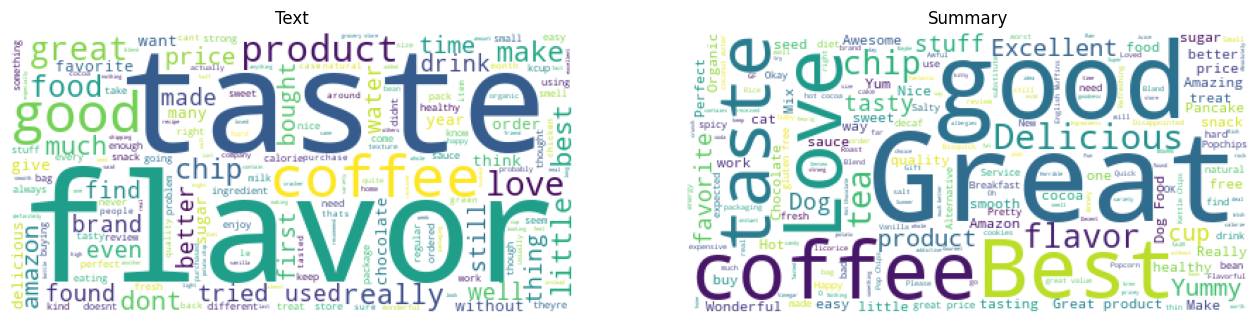

In [20]:
label = 2

df1 = df[df.iloc[:,3]==label]['Text'].dropna()
df2 = df[df.iloc[:,3]==label]['Summary'].dropna()

f, ax = plt.subplots(1,2,figsize=(16,16))
wordcloud1 = WordCloud(background_color='white').generate(" ".join(df1))
wordcloud2 = WordCloud(background_color='white').generate(" ".join(df2))

ax[0].imshow(wordcloud1)
ax[1].imshow(wordcloud2)
ax[0].set_title('Text')
ax[1].set_title('Summary')
ax[1].axis('off')
ax[0].axis('off')

plt.show()